In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib qt

DBG = True
NO_DBG = False
CB_X = 6
CB_Y = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CB_X * CB_Y, 3), np.float32)
objp[:,:2] = np.mgrid[0 : CB_Y, 0 : CB_X].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CB_Y, CB_X), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (CB_Y, CB_X), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## Apply a distortion correction to raw images

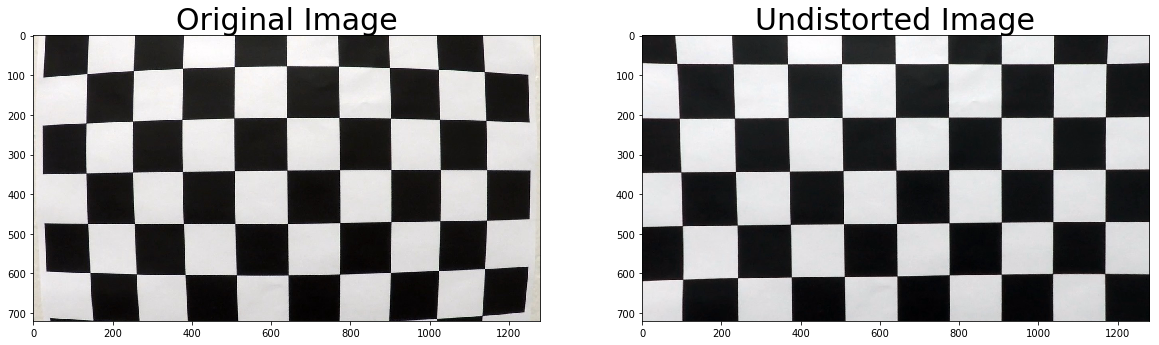

In [2]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
G_SHAPE = img.shape
G_W = G_SHAPE[1]
G_H = G_SHAPE[0]

# Find camera calibration parameters given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   img_size,
                                                   None,
                                                   None)

# Helper function to undistort images
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort(img)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

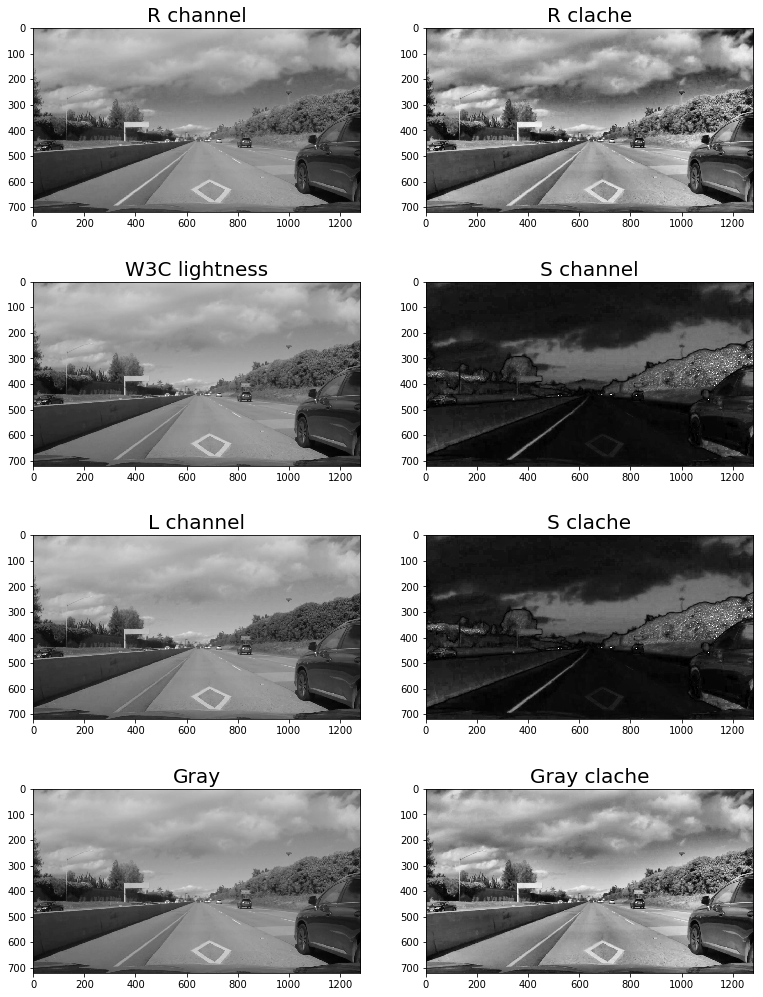

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fname = 'test_images/straight_lines2.jpg'
img = mpimg.imread(fname) 

clip_names = ["project_video.mp4",
              "challenge_video.mp4",
              "harder_challenge_video.mp4"]

if 1:
    frame_num = 451
    clip1 = VideoFileClip(clip_names[1])
    img = clip1.get_frame(float(frame_num)/clip1.fps)


# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(channel, thresh=(0, 255), ch='s'):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    channel = 0
    if ch == 'h':
        channel = hls[:,:,0]
    elif ch == 'l':
        channel = hls[:,:,1]
    else:
        channel = hls[:,:,2]
    
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

def channel_select(channel, thresh=(0, 255)):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
hls_binary = hls_select(img, thresh=(90, 255))

# Plot different channels
G_CLACHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
G_CLACHE_STR = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]

r_cl = G_CLACHE.apply(r_channel)
g_cl = G_CLACHE.apply(g_channel)
s_cl = G_CLACHE.apply(s_channel)

wl = np.uint8(r_channel*0.299 + g_channel*0.587 + b_channel*0.1170)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cl = G_CLACHE.apply(gray)


#f, (ax) = plt.subplots(3, 2, figsize=(15, 15))
#ax[0, 0].imshow(h_channel, cmap='gray')
#ax[0, 0].set_title('H channel', fontsize=50)
#ax[0, 1].imshow(l_channel, cmap='gray')
#ax[0, 1].set_title('L channel', fontsize=50)
#ax[1, 0].imshow(s_channel, cmap='gray')
#ax[1, 0].set_title('S channel', fontsize=50)
#ax[1, 1].imshow(r_channel, cmap='gray')
#ax[1, 1].set_title('R channel', fontsize=50)
#ax[2, 0].imshow(g_channel, cmap='gray')
#ax[2, 0].set_title('G channel', fontsize=50)
#ax[2, 1].imshow(b_channel, cmap='gray')
#ax[2, 1].set_title('B channel', fontsize=50)

f, (ax) = plt.subplots(4, 2, figsize=(10, 15))
ax[0, 0].imshow(r_channel, cmap='gray')
ax[0, 0].set_title('R channel', fontsize=20)
ax[0, 1].imshow(r_cl, cmap='gray')
ax[0, 1].set_title('R clache', fontsize=20)
ax[1, 0].imshow(wl, cmap='gray')
ax[1, 0].set_title('W3C lightness', fontsize=20)
ax[1, 1].imshow(s_channel, cmap='gray')
ax[1, 1].set_title('S channel', fontsize=20)

ax[2, 0].imshow(l_channel, cmap='gray')
ax[2, 0].set_title('L channel', fontsize=20)
ax[2, 1].imshow(s_channel, cmap='gray')
ax[2, 1].set_title('S clache', fontsize=20)
ax[3, 0].imshow(gray, cmap='gray')
ax[3, 0].set_title('Gray', fontsize=20)
ax[3, 1].imshow(cl, cmap='gray')
ax[3, 1].set_title('Gray clache', fontsize=20)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

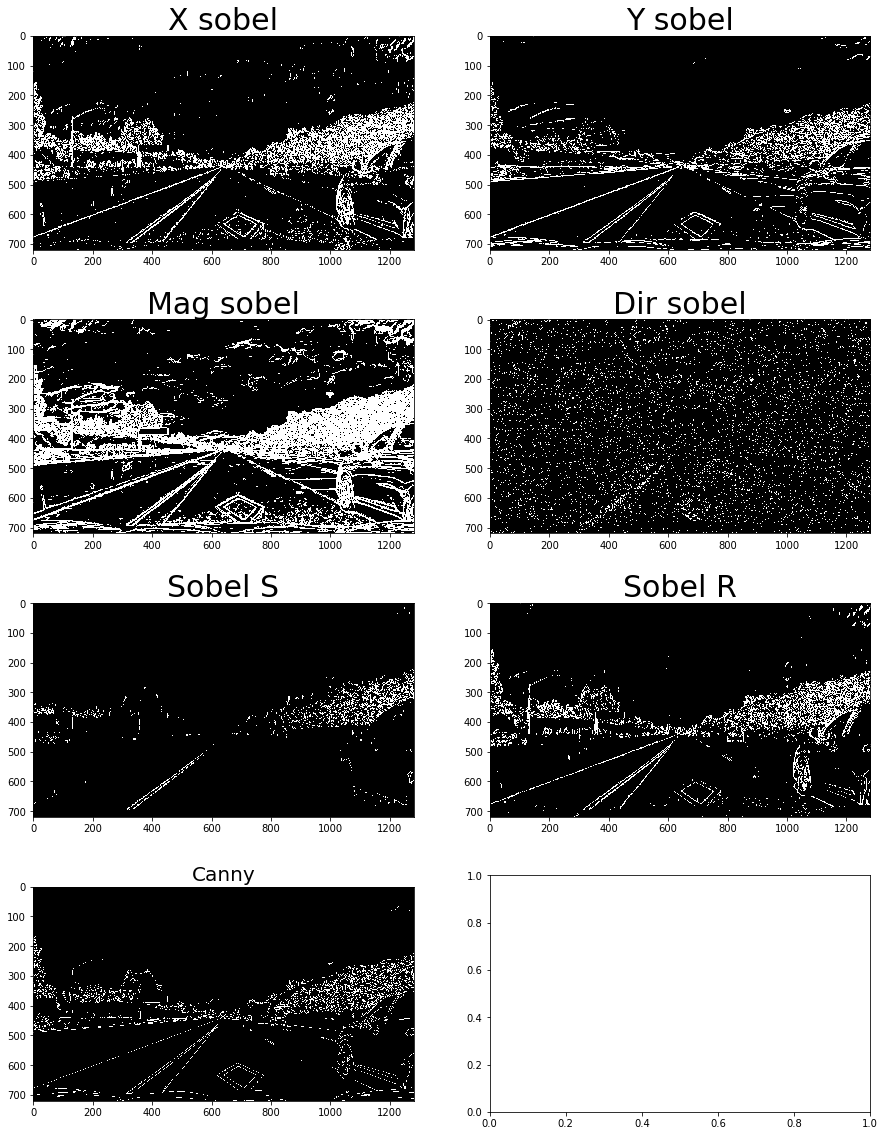

In [14]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def abs_sobel_thresh_hls(img, orient='x', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    if orient == 'x':
        sobel = cv2.Sobel(hls, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(hls, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def abs_raw_sobel(channel, orient='x', thresh=(30, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_mag = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(dir, dtype=np.uint8)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)
    
# Run the function
x_sobel = abs_raw_sobel(cl, 'x', (10, 255))
y_sobel = abs_raw_sobel(cl, 'y', (20, 255))
mag_sobel = mag_thresh(cl, 5, (10, 255))
dir_sobel = dir_thresh(img, sobel_kernel=15, thresh=(0.95, 1.05)) #thresh=(0.7, 1.3))
sobel_S = abs_raw_sobel(s_channel, 'x', (20, 255))
x_sobel_R = abs_raw_sobel(r_cl, 'x', (20, 255))
cny = canny(img, 50, 150)

# Plot the result
f, ax = plt.subplots(4, 2, figsize=(15, 20))
ax[0, 0].imshow(x_sobel, cmap='gray')
ax[0, 0].set_title('X sobel', fontsize=30)
ax[0, 1].imshow(y_sobel, cmap='gray')
ax[0, 1].set_title('Y sobel', fontsize=30)
ax[1, 0].imshow(mag_sobel, cmap='gray')
ax[1, 0].set_title('Mag sobel', fontsize=30)
ax[1, 1].imshow(dir_sobel, cmap='gray')
ax[1, 1].set_title('Dir sobel', fontsize=30)
ax[2, 0].imshow(sobel_S, cmap='gray')
ax[2, 0].set_title('Sobel S', fontsize=30)
ax[2, 1].imshow(x_sobel_R, cmap='gray')
ax[2, 1].set_title('Sobel R', fontsize=30)
ax[3, 0].imshow(cny, cmap='gray')
ax[3, 0].set_title('Canny', fontsize=20)


#f.tight_layout()
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(mag_binary, cmap='gray')
#ax2.set_title('Thresholded Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

undist = undistort(img)

# Edit this function to create your own pipeline.
def make_binary(img):
    img = np.copy(img)
    
    # Select different channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    R_channel = img[:,:,0]
    G_channel = img[:,:,1]
    B_channel = img[:,:,2]
    
    H_channel = hls[:,:,0]
    L_channel = hls[:,:,1]
    S_channel = hls[:,:,2]
    
    wl = np.uint8(R_channel*0.299 + G_channel*0.587 + B_channel*0.1170)
    
    if 1:
        gray = G_CLACHE.apply(gray)
        R_channel = G_CLACHE.apply(img[:,:,0])
        G_channel = G_CLACHE.apply(img[:,:,1])
        B_channel = G_CLACHE.apply(img[:,:,2])
        #S_channel = G_CLACHE.apply(hls[:,:,2])
        #L_channel = G_CLACHE.apply(L_channel)
    
    # Threshold HLS
    #S_filtered = channel_select(S_channel, (230, 255))
    S_sobel = abs_raw_sobel(S_channel, 'x', (30, 255))
    #sobel_r = abs_raw_sobel(R_channel, 'x', (10, 255))
    HLS_binary = S_sobel #| S_filtered
    
    zeros = np.zeros_like(HLS_binary)
    
    # Threshold based on sobel edge detection
    sobel_x = abs_raw_sobel(gray, 'x', (25, 255))
    S_filtered_low = channel_select(S_channel, (0, 10))
    S_filtered_low = cv2.dilate(S_filtered_low, np.ones((5,5)), iterations = 1)
    R_filtered_low = channel_select(R_channel, (0, 100))
    sobel_x[(S_filtered_low == 1)] = 0
    sobel_x[(R_filtered_low == 1)] = 0
    #sobel_x[(grey_reg == 1)] = 0
    
    #sobel_mag = mag_thresh(gray, 5, (30, 40))
    sobel_dark = abs_raw_sobel(gray, 'x', (10, 255))
    L_filtered = channel_select(wl, (70, 255))
    L_dilated = cv2.dilate(L_filtered, np.ones((5,5)), iterations = 1)
    sobel_dark[(L_dilated == 1) | (S_filtered_low == 1)] = 0
       
    #detect dark edges
    sobel = sobel_x | sobel_dark

               
        
        
    # Color threshold
    #R_sobel = mag_thresh(R_channel, 5, (30, 255))
    RGB_binary = np.zeros_like(HLS_binary)
    #RGB_binary = channel_select(R_channel, (200, 255))
    #RGB_binary = abs_raw_sobel(R_channel, 'x', (25, 255))
    
    # Yellow filter
    R_filtered = channel_select(R_channel, (160, 255))
    G_filtered = channel_select(G_channel, (160, 255))
    B_filtered = channel_select(B_channel, (0, 130))
    RGB_binary[(R_filtered == 1) & (G_filtered == 1) & (B_filtered == 1)] = 1
    
    # White filter
    #R_filtered = channel_select(R_channel, (220, 255))
    #G_filtered = channel_select(G_channel, (220, 255))
    #B_filtered = channel_select(B_channel, (220, 255))
    #RGB_binary[(R_filtered == 1) & (G_filtered == 1) & (B_filtered == 1)] = 1
    
    #H_filtered = channel_select(H_channel, (20, 26))
    #L_filtered = channel_select(L_channel, (170, 255))
    #RGB_binary[(H_filtered == 1) & (L_filtered == 1)] = 1
    
    #diff1 = abs(np.int32(R_channel) - np.int32(G_channel))
    #diff2 = abs(np.int32(G_channel) - np.int32(B_channel))
    #grey_reg = np.zeros_like(HLS_binary)
    #grey_reg[(diff1 <= 10) & (diff2 <= 10)] = 1
    white_sel = channel_select(gray, (210, 255))
    L_filtered = channel_select(wl, (0, 150))
    L_dilated = cv2.dilate(L_filtered, np.ones((5,5)), iterations = 1)
    white_sel[(L_dilated != 1)] = 0
    
    sobel_light = abs_raw_sobel(wl, 'x', (25, 255))
    L_filtered = channel_select(wl, (0, 120))
    L_dilated = cv2.dilate(L_filtered, np.ones((5,5)), iterations = 1)
    sobel_light[(L_dilated == 1)] = 0
    #plt.figure(figsize=(15, 15))
    #plt.imshow(S_filtered_low, cmap='gray')
    
    
    RGB_binary[(white_sel == 1) | (sobel_light == 1)] = 1

    
    # Stack each channel
    #color_binary = np.dstack((zeros, sobel, zeros)) * 255
    color_binary = np.dstack((HLS_binary, sobel, RGB_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel)
    combined_binary[(HLS_binary == 1) | (sobel == 1) | (RGB_binary == 1)] = 1
    return (combined_binary, color_binary)
    
(comb_bin, col_bin) = make_binary(undist)

# Plot the result
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 25))

#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=20)

#ax2.imshow(col_bin)
#ax2.set_title('Pipeline Result', fontsize=20)

#ax3.imshow(comb_bin, cmap='gray')
#ax3.set_title('Combined binary', fontsize=20)

#base = os.path.splitext(os.path.basename(fname))[0]
#mpimg.imsave('output_dbg/dbg_' + base + '.png', res)

# vid1 548;
# vid2 80 - 4 lanes
#      131 - tunnel
#      152 - after tunnel
frames = [[548],
          [0, 12, 29, 80, 125, 131, 145, 152, 157, 263, 451],
          [0, 344]]

for idx, clip_name in enumerate(clip_names):
    clip1 = VideoFileClip(clip_name)

    for frame_num in frames[idx]:
        timg = clip1.get_frame(float(frame_num)/clip1.fps)
        und = undistort(timg)
        (binary, dbg) = make_binary(und)
        dbg = np.concatenate((und, dbg), axis=1)
        mpimg.imsave('output_dbg/a_vid' + str(idx) + '_dbg_' + str(frame_num) + '.png', dbg)

## Perspective rectangle detection

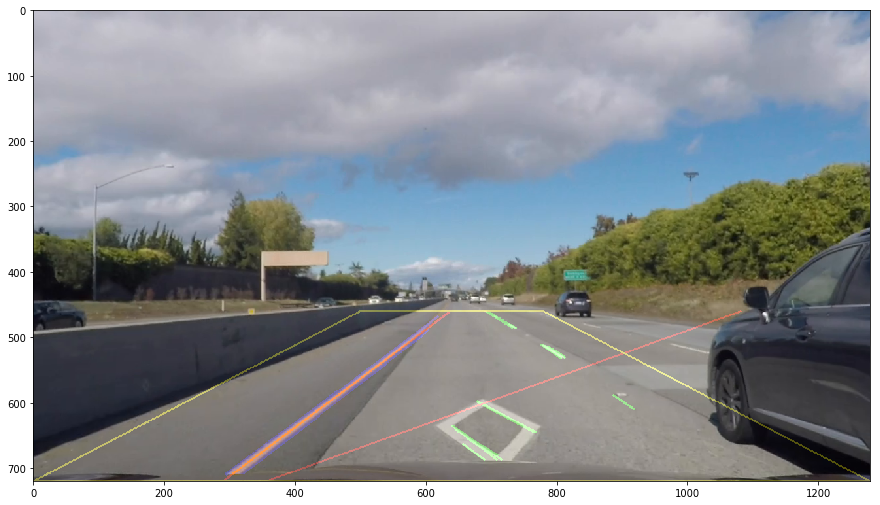

In [16]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import  math

Y_EDGE = 460
X_MARGIN = 500
Y_MARGIN = 460
X_MIDDLE = G_SHAPE[1] / 2
# Crop region of interest 
CROP_REC = [[0, G_SHAPE[0]], # left bottom
            #[0, G_SHAPE[0] - Y_MARGIN],
            [X_MARGIN, Y_EDGE], # left top
            [G_SHAPE[1] - X_MARGIN, Y_EDGE], # right top
            #[SHAPE[1], SHAPE[0] - Y_MARGIN],
            [G_SHAPE[1], G_SHAPE[0]]] # right bottom

VOTES = 15
LINE_PIX = 25
MAX_GAP = 30

LMARGIN = 220
HMARGIN = 580
#src_corners = [[150, img_size[1]], # left bottom
#               [640, 460], # left top
#               [700, 460], # right top
#               [1035, img_size[1]]] # right bottom

G_SRC_CORNERS = [[LMARGIN, G_H], # left bottom
                 [HMARGIN, 460], # left top
                 [G_W - HMARGIN, 460], # right top
                 [G_W - LMARGIN, G_H]] # right bottom

G_DST_CORNERS = [[280, img_size[1]], [280, 0], [1000, 0], [1000, img_size[1]]]

# Helper class
class RefPoints:
    def __init__(self, y_ed, x_mi):
        self.y_edge = y_ed       # y coordinate of the top edge of clip region
        self.x_middle = x_mi     # x coordinate of the middle of the top edge
                                 # of clip region

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def my_region_of_interest(img, vertices, inv):
    """
    Applies an image mask.
    
    If inv == False keeps the region of the image defined by the polygon.
    If inv == True keeps the outer region of the image defined by the polygon.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    color = 255
    if inv:
        mask.fill(255)
        color = 0
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        mask_color = (color,) * channel_count
    else:
        mask_color = color
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, mask_color)
    
    #returning the image only 255where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def find_line(x_dots, y_dots, ref_pts):
    if x_dots is not None:
        A = np.vstack([x_dots, np.ones(len(x_dots))]).T     
        m, c = np.linalg.lstsq(A, y_dots)[0]
        x1 = int((img.shape[0] - c)/m)
        y1 = int(img.shape[0])
        x2 = int((ref_pts.y_edge - c)/m)
        y2 = int(ref_pts.y_edge)
        return [(x1, y1), (x2, y2)]
    else:
        return None

def detect_lines(lines, ref_pts, dbg_img):
    if lines is None:
        return None, None
    
    if lines.size == 0:
        return None, None
    
    left_x = [] # x coordinates of left lane dots
    left_y = [] # y coordinates of left lane dots
    right_x = [] # x coordinates of right lane dots
    right_y = [] # y coordinates of right lane dots|
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/float(x2-x1)
            
            if x1 > ref_pts.x_middle and x2 > ref_pts.x_middle and slope >= 0.5 and slope <= 1:
                right_x.extend([x1, x2])
                right_y.extend([y1, y2])
                cv2.line(dbg_img, (x1, y1), (x2, y2), [0, 255, 0], 2)
            elif x1 < ref_pts.x_middle and x2 < ref_pts.x_middle and slope >= -1 and slope <= -0.5:
                left_x.extend([x1, x2])
                left_y.extend([y1, y2])
                cv2.line(dbg_img, (x1, y1), (x2, y2), [0, 0, 255], 2)
    
    l_line = find_line(left_x, left_y, ref_pts)
    r_line = find_line(right_x, right_y, ref_pts)
       
    return l_line, r_line

def detect_lanes(binary):
    """
    Line detection algorithm is implemented inside this method.
    Return image with drawn lines on it.
    """   
    # Crop region of interest 
    img = my_region_of_interest(binary, np.array([CROP_REC], dtype=np.int32), False)
    #img = my_region_of_interest(img, np.array([crop_reg2], dtype=np.int32), True)

    # Detect lines
    ref_pts = RefPoints(Y_EDGE, X_MIDDLE)
    lines = cv2.HoughLinesP(img, 1, np.pi/180, VOTES, np.array([]), LINE_PIX, MAX_GAP)
    
    dbg_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    left_l, right_l = detect_lines(lines, ref_pts, dbg_img)
    
    return left_l, right_l, dbg_img

def calc_persp_matr(l_line, r_line):
    if l_line and r_line:
        (x1, y1) = l_line[0]
        (x2, y2) = l_line[1]
        (x3, y3) = r_line[0]
        (x4, y4) = r_line[1]

        L = x2 - x1
        R = x3 - x4
        W_top = x4 - x2
        H = y1 - y2

        if L > 0 and R > 0 and W_top > 0 and H > 0:
            off = (150.0 - W_top) * H / (L + R)                  

            src = np.float32([l_line[0],
                              (x2 - L * off / H, y2 + off),
                              (x4 + R * off / H, y4 + off),
                              r_line[0]])
            dst = np.float32(G_DST_CORNERS)
            M = cv2.getPerspectiveTransform(src, dst)
            M_inv = cv2.getPerspectiveTransform(dst, src)
            return M, M_inv, src
    
    return None, None, None
            

l_line, r_line, dbg_lines = detect_lanes(comb_bin)
new_M, new_M_inv, corners = calc_persp_matr(l_line, r_line)

if l_line:
    cv2.line(dbg_lines, l_line[0], l_line[1], [255, 0, 0], 2)
        
if r_line:
    cv2.line(dbg_lines, r_line[0], r_line[1], [255, 0, 0], 2)

cv2.polylines(dbg_lines,
              [np.array(CROP_REC, dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,255,0),
              thickness=2)

if corners is not None:
    cv2.polylines(dbg_lines,
                  [np.array(corners, dtype=np.int32).reshape((-1, 1, 2))],
                  True,
                  (0,255,255),
                  thickness=2)

det_lines_colored = cv2.addWeighted(undist, 1, dbg_lines, 0.3, 0)

plt.figure(figsize=(15, 15))
plt.imshow(det_lines_colored)

## Apply a perspective transform to rectify binary image ("birds-eye view")

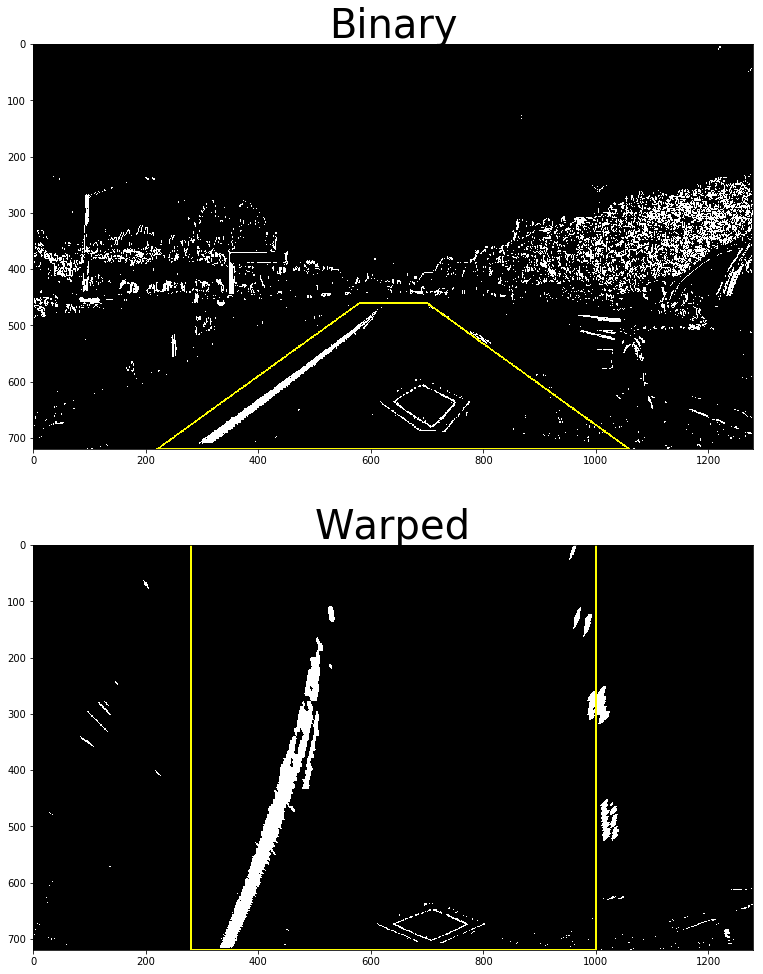

In [17]:
src = np.float32(G_SRC_CORNERS)
dst = np.float32(G_DST_CORNERS)
m = cv2.getPerspectiveTransform(src, dst)
m_inv = cv2.getPerspectiveTransform(dst, src)
G_M = m
G_M_inv = m_inv

if new_M is not None:
    m = new_M
    
if new_M_inv is not None:
    m_inv = new_M_inv
    
if corners is None:
    corners = G_SRC_CORNERS

def perspective_transform(img, M, debug = False):  
    warped = cv2.warpPerspective(img,
                                 M,
                                 (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR)

    return warped

warped = perspective_transform(comb_bin, m)

# Plot the result
colored_comb_bin = np.dstack((comb_bin, comb_bin, comb_bin)) * 255
cv2.polylines(colored_comb_bin,
              [np.array(corners, dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,0,0),
              thickness = 2)
cv2.polylines(colored_comb_bin,
              [np.array(G_SRC_CORNERS,dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,255,0),
              thickness = 2)

colored_warped = np.dstack((warped, warped, warped)) * 255
cv2.polylines(colored_warped,
              [np.array(G_DST_CORNERS, dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,255,0),
              thickness=2)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))
f.tight_layout()

ax1.imshow(colored_comb_bin)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(colored_warped)
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Detect lane pixels and fit to find the lane boundary.

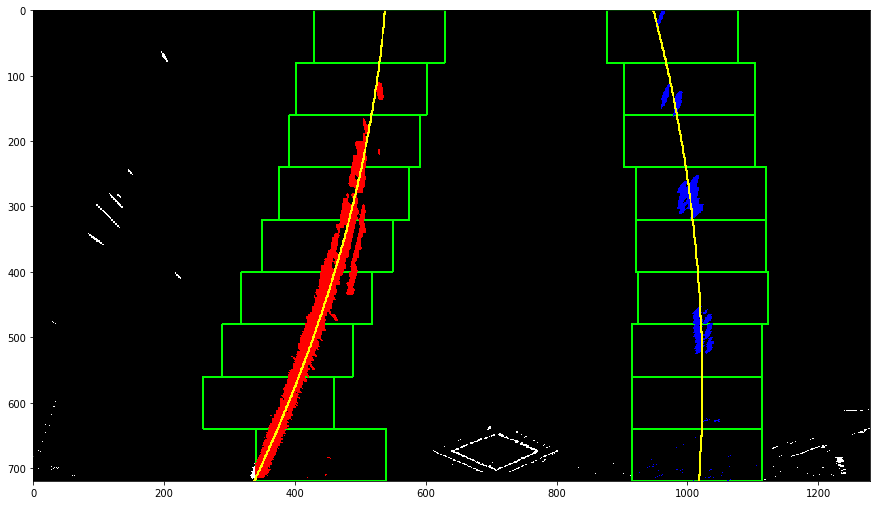

In [18]:
def find_lane_pixels(binary_warped, vis):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = 0
    if vis:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 150

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_off = 0
    right_off = 0

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ##Find the four below boundaries of the window
        win_xleft_low = leftx_current  - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if vis:
            cv2.rectangle(out_img,
                          (win_xleft_low,win_y_low),
                          (win_xleft_high,win_y_high),
                          (0,255,0),
                          2) 
            cv2.rectangle(out_img,
                          (win_xright_low,win_y_low),
                          (win_xright_high,win_y_high),
                          (0,255,0),
                          2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_mean = np.int(np.mean(nonzerox[good_left_inds]))
            leftx_current = leftx_mean
            
        if len(good_right_inds) > minpix:
            rightx_mean = np.int(np.mean(nonzerox[good_right_inds]))
            rightx_current = rightx_mean

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, vis):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, vis)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    if vis:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        cv2.polylines(out_img,
                      [np.array([left_fitx, ploty], dtype=np.int32).T],
                      False,
                      (255,255,0),
                      thickness=2)
        cv2.polylines(out_img,
                      [np.array([right_fitx, ploty], dtype=np.int32).T],
                      False,
                      (255,255,0),
                      thickness=2)
        

    return ploty, left_fit, right_fit, left_fitx, right_fitx, out_img

py, lf, rf, lfx, rfx, vis = fit_polynomial(warped, True)

# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(15, 15))
#plt.plot(lfx, py, color='yellow')
#plt.plot(rfx, py, color='yellow')
plt.imshow(vis)

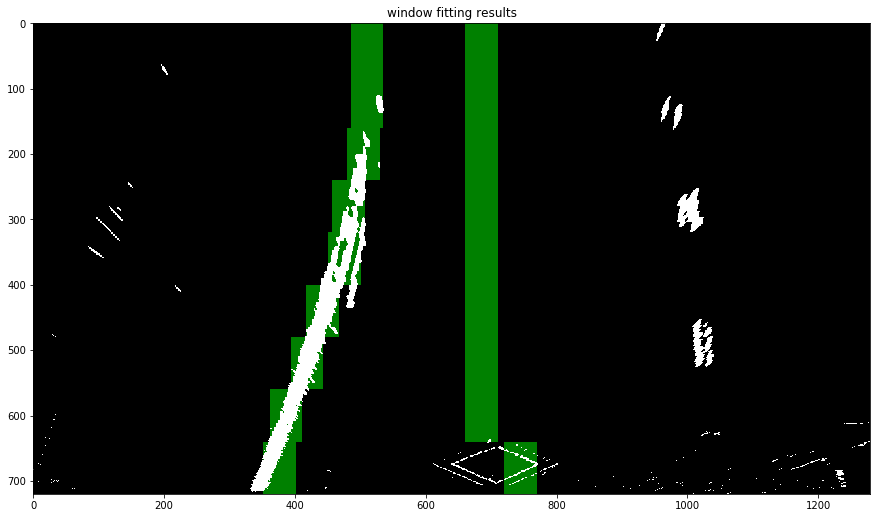

In [19]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center + offset - margin,0))
        l_max_index = int(min(l_center + offset + margin, image.shape[1]))
        if np.any(conv_signal[l_min_index:l_max_index] > 0):
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        if np.any(conv_signal[r_min_index:r_max_index] > 0):
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def search_conv(binary_warped):
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows 	
        for level in range(0, len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_mask == 1)] = 255
            r_points[(r_mask == 1)] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)
        
    return output

output = search_conv(warped)
# Display the final results
plt.figure(figsize=(15, 15))
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Search from prior

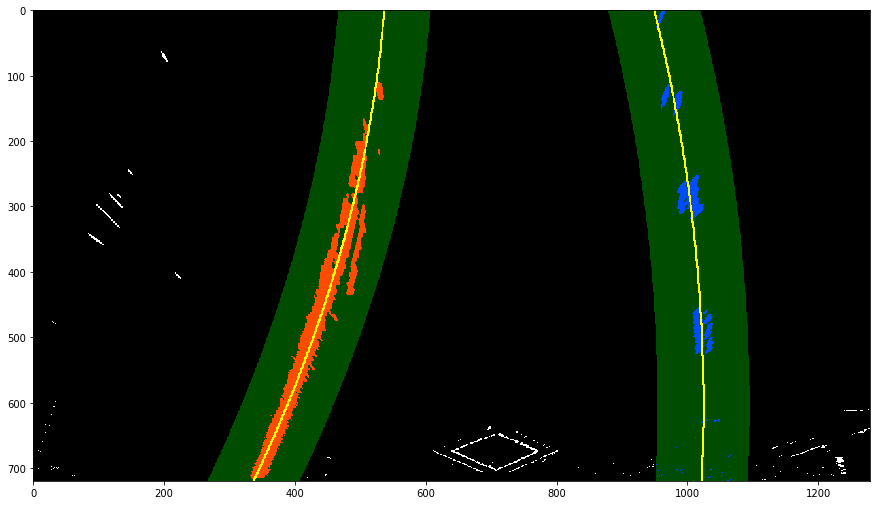

In [20]:
def fit_poly(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    
def find_poly_values(left_fit, right_fit, img_shape):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    min_found = 500
    new_left_fit, new_right_fit = None, None
    if len(leftx) < min_found or len(rightx) < min_found:
        new_left_fit = left_fit
        new_right_fit = right_fit
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        return ploty, new_left_fit, new_right_fit, None, None, out_img
    else:
        # Fit new polynomials
        new_left_fit, new_right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    left_fitx, right_fitx, ploty = find_poly_values(new_left_fit, new_right_fit,
                                                    binary_warped.shape)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.polylines(out_img,
                  [np.array([left_fitx, ploty], dtype=np.int32).T],
                  False,
                  (255,255,0),
                  thickness=2)
    cv2.polylines(out_img,
                  [np.array([right_fitx, ploty], dtype=np.int32).T],
                  False,
                  (255,255,0),
                  thickness=2)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
    return ploty, new_left_fit, new_right_fit, left_fitx, right_fitx, result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
py, lf, rf, lfx, rfx, vis2 = search_around_poly(warped, lf, rf)

# View your output
# Plot the polynomial lines onto the image
plt.figure(figsize=(15, 15))
#plt.plot(lfx, py, color='yellow')
#plt.plot(rfx, py, color='yellow')
## End visualization steps ##
plt.imshow(vis2)

## Determine the curvature of the lane and vehicle position with respect to center.

In [21]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Do the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    pos = (img_size[0]/2 - (left_fitx[-1] + right_fitx[-1])/2) * xm_per_pix
    

    return left_curverad, right_curverad, pos

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, pos = measure_curvature_real(py, lfx, rfx)
print(left_curverad, 'm', right_curverad, 'm', pos, 'm')

594.918824699 m 799.574953178 m -0.211405613378 m


## Warp the detected lane boundaries back onto the original image.

In [22]:
def draw_lane(undist, warped, left_fitx, right_fitx, ploty, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (G_W, G_H)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

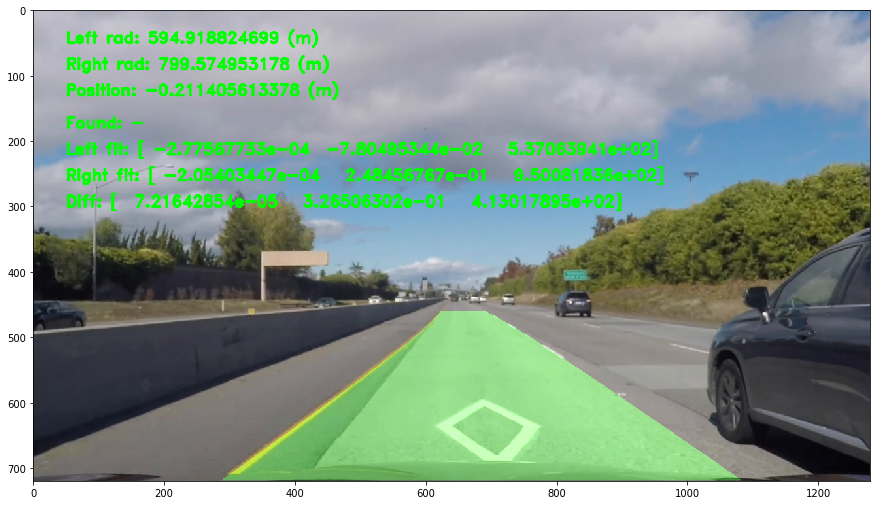

In [23]:
import cv2

def draw_text(img, l_curverad, r_curverad, relative_pos,
              is_found = None, left_fit = None, right_fit = None):
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,
                'Left rad: ' + str(l_curverad) + ' (m)',
                (50, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img,
                'Right rad: ' + str(r_curverad) + ' (m)',
                (50, 90), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img,
                'Position: ' + str(relative_pos) + ' (m)' ,
                (50, 130), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    
    if left_fit is not None and right_fit is not None:
        cv2.putText(img,
                    'Found: ' + str(is_found),
                    (50, 180), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)        
        cv2.putText(img,
                    'Left fit: ' + str(left_fit),
                    (50, 220), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(img,
                    'Right fit: ' + str(right_fit),
                    (50, 260), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(img,
                    'Diff: ' + str(right_fit - left_fit),
                    (50, 300), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    
    return img

result = draw_lane(undist, warped, lfx, rfx, py, m_inv)
result = draw_text(result, left_curverad, right_curverad, pos, '-', lf, rf)


plt.figure(figsize=(15, 15))
plt.imshow(result)

## Pipeline

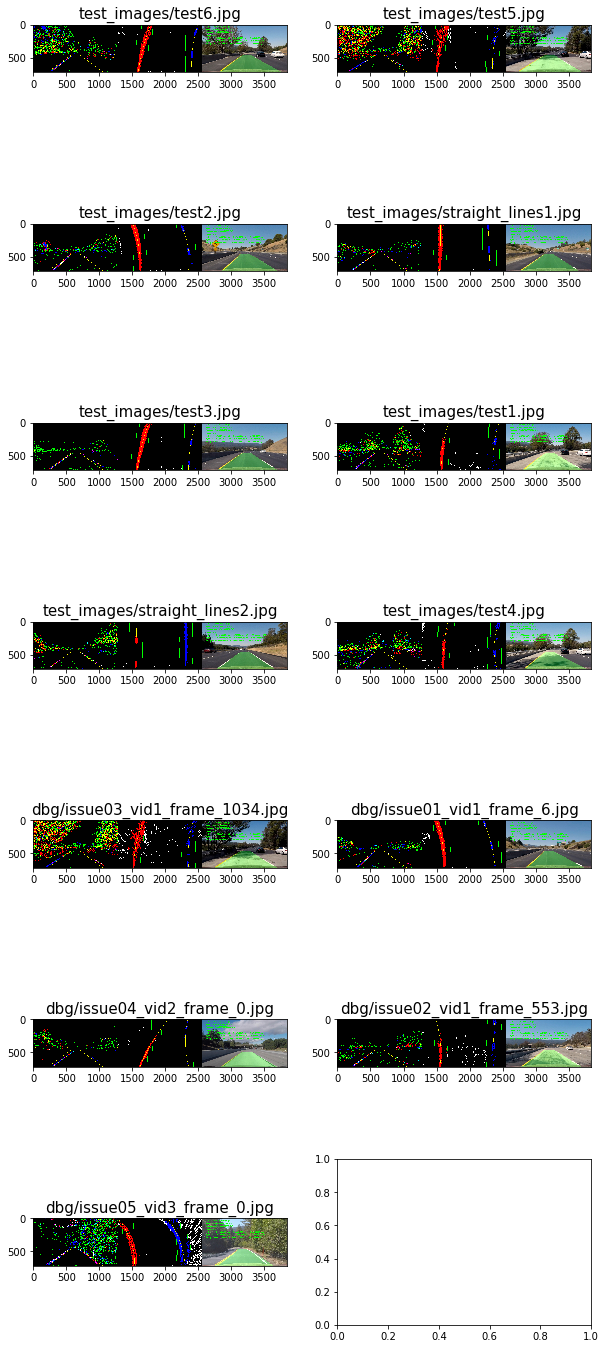

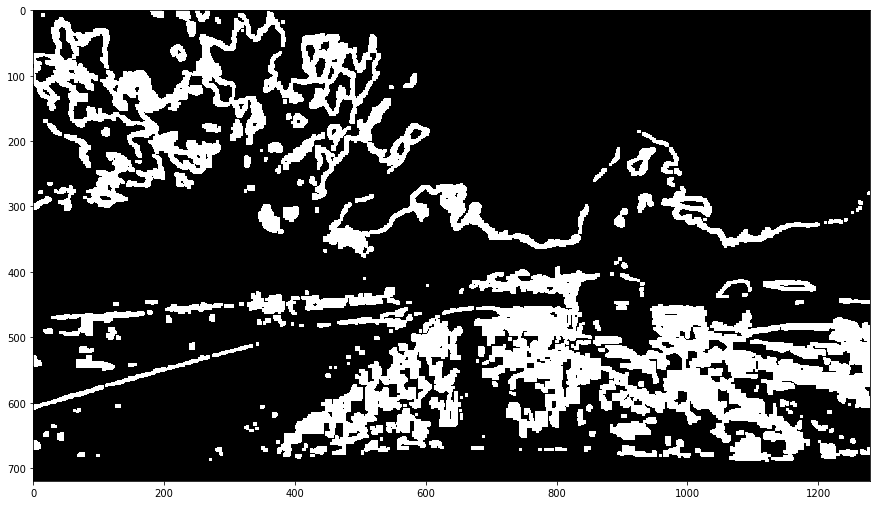

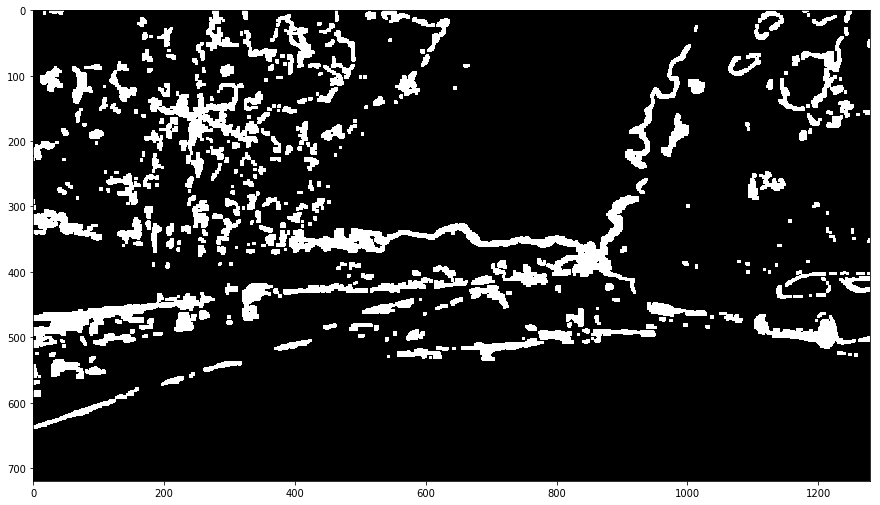

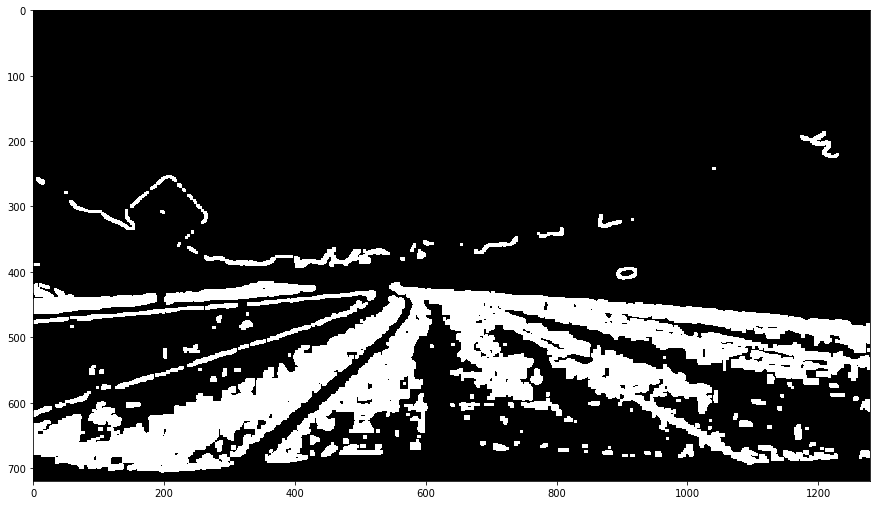

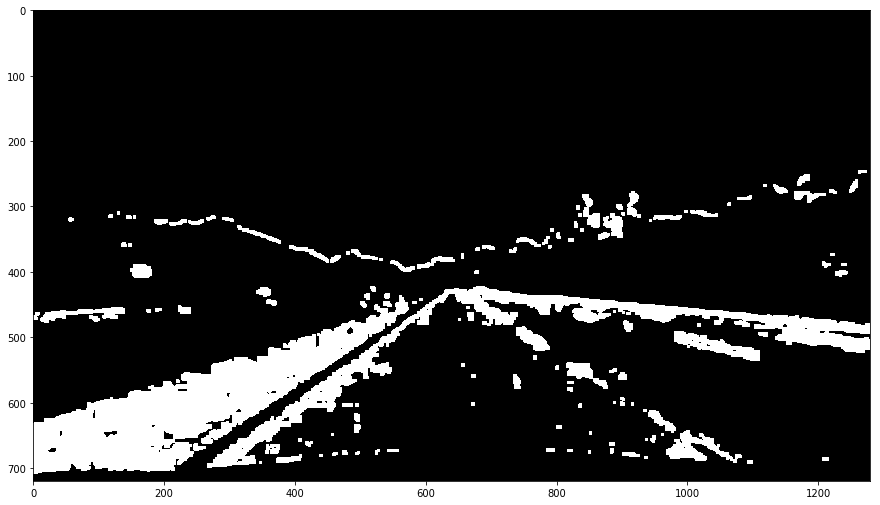

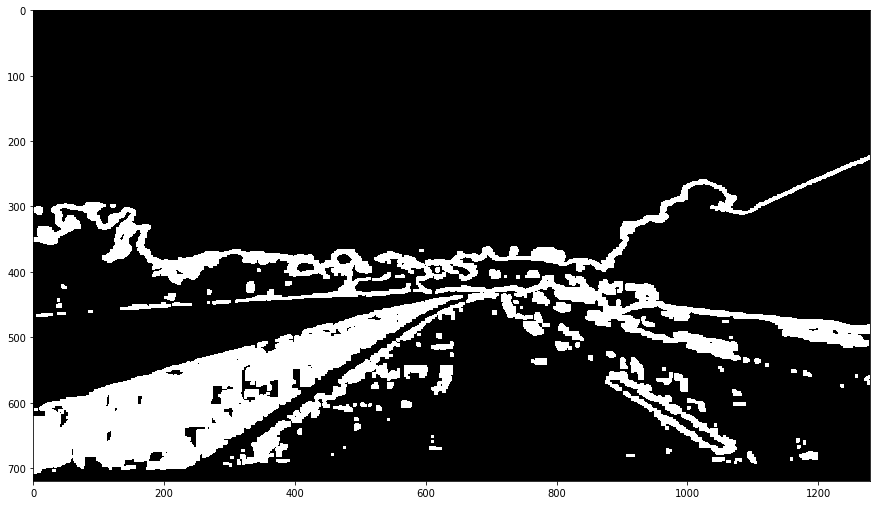

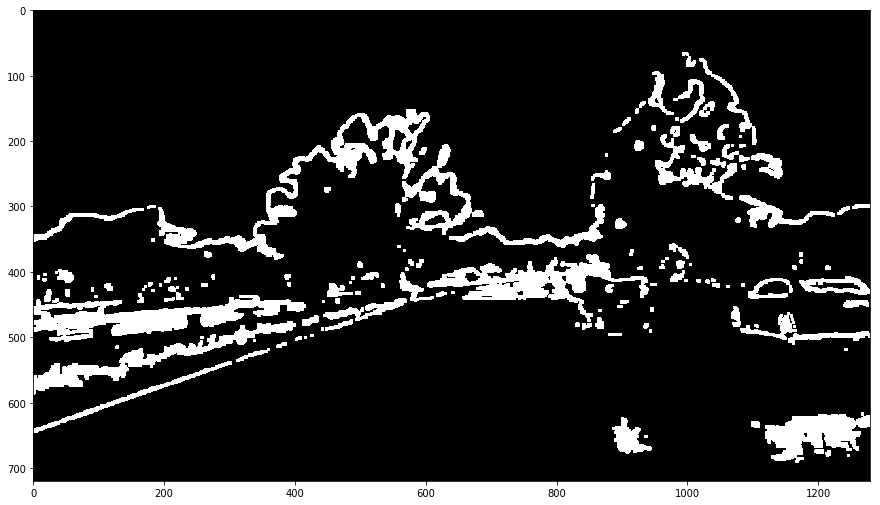

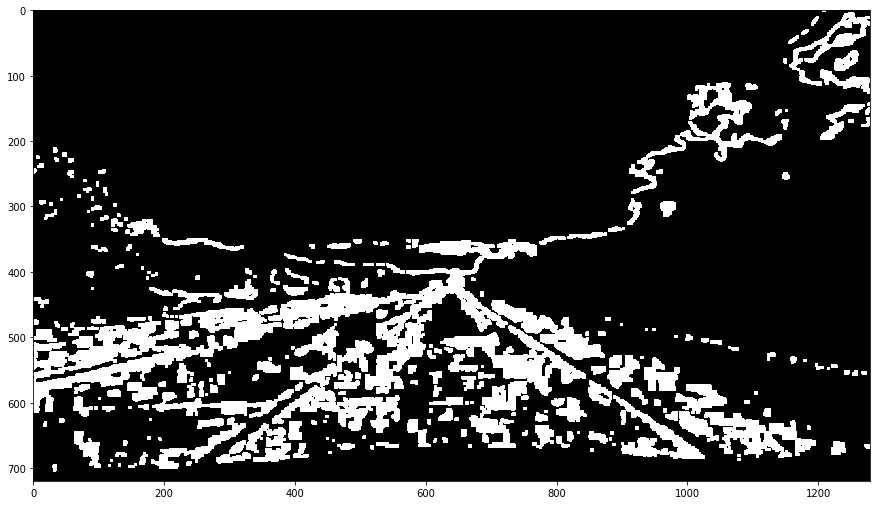

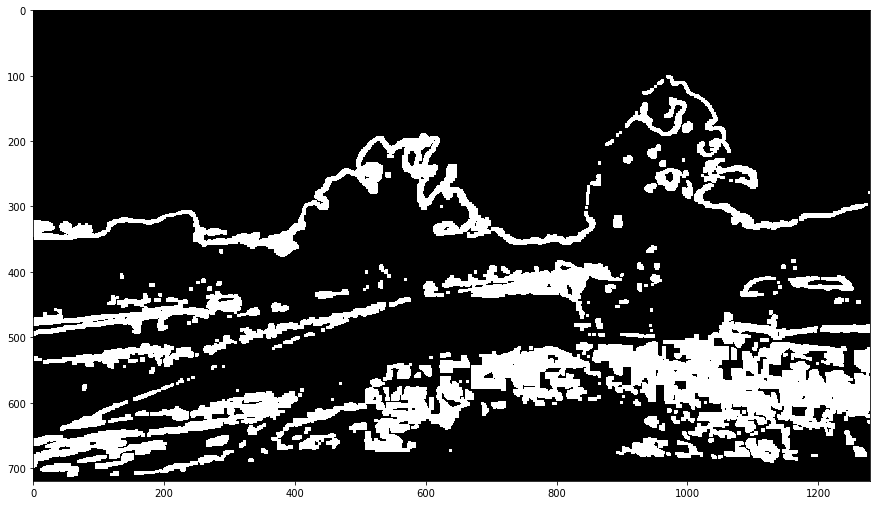

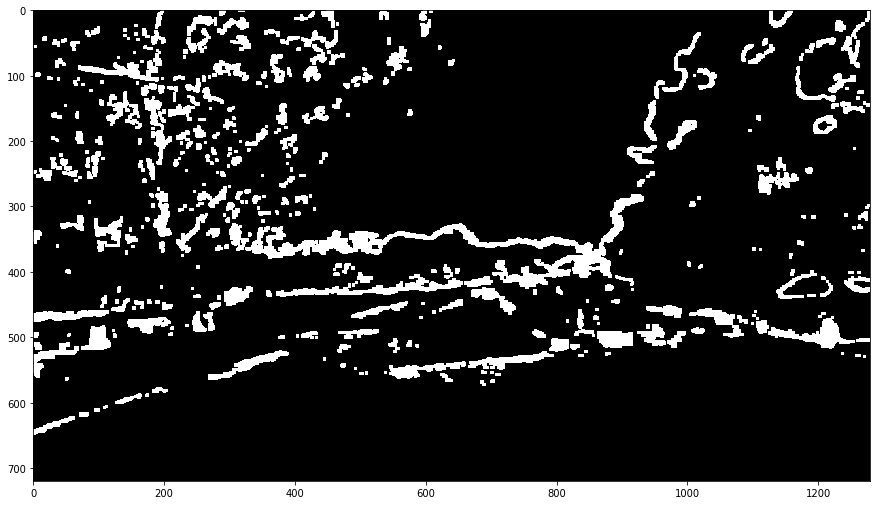

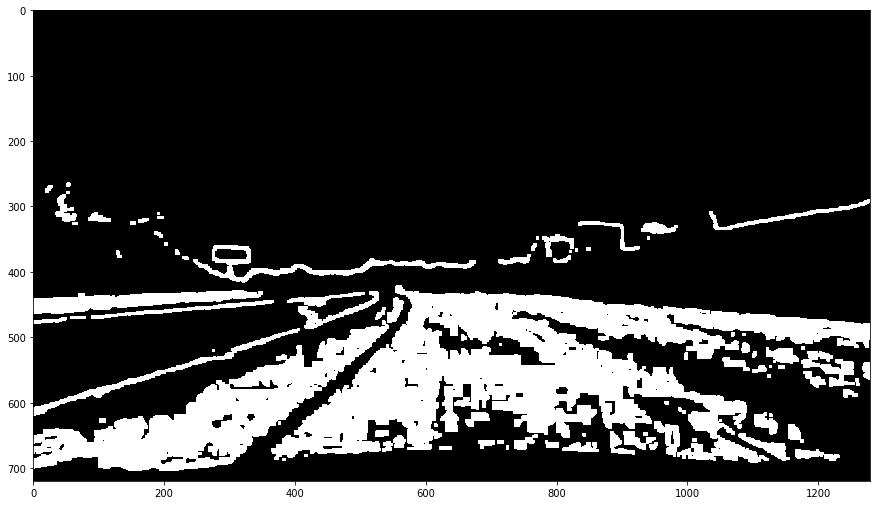

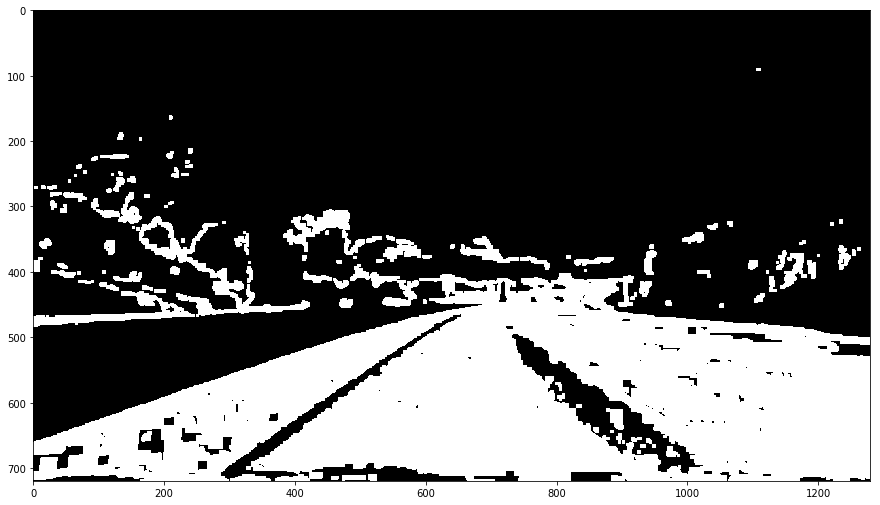

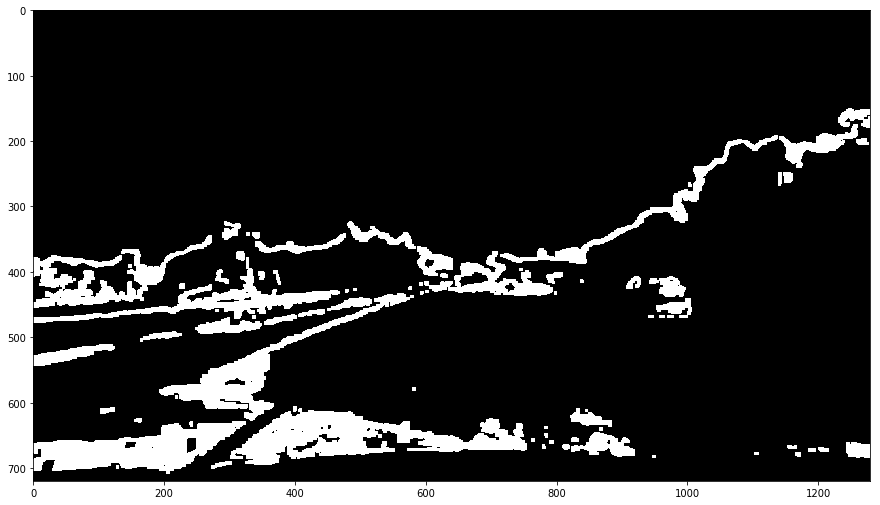

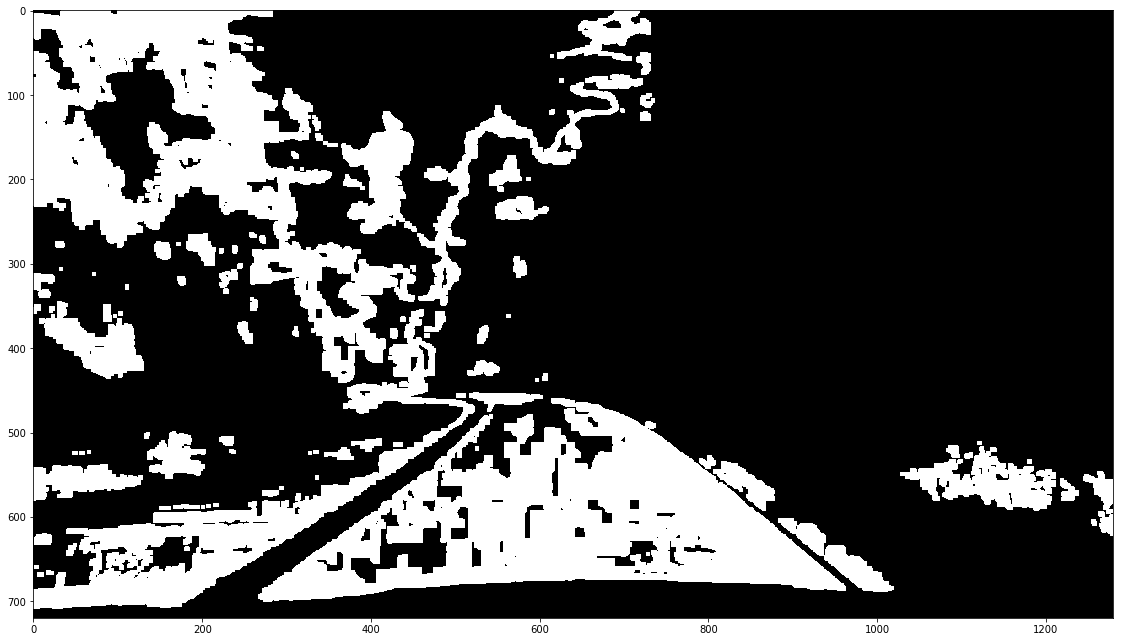

In [24]:
import os

MAX_LOST_FRAMES = 5

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False  # was the line detected in the last iteration?
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None #average x values of the fitted line over the last n iterations
        self.best_fit = None #polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])] #polynomial coefficients for the most recent fit  
        self.rad = None #radius of curvature of the line in some units
        self.line_base_pos = None #distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits
        self.allx = None #x values for detected line pixels
        self.ally = None #y values for detected line pixels

class ProcessSeq:
    def __init__(self):
        self.l_lane = Line()
        self.r_lane = Line()
        self.M = G_M
        self.M_inv = G_M_inv
        self.lost_frames = MAX_LOST_FRAMES
        self.line_pos = 0
        self.corners = G_SRC_CORNERS
        
    def update_perspective_transform(self, lf, rf, lfx, rfx):
        # Translate lines coordinates to original image
        left_dots = cv2.perspectiveTransform(np.array([np.array([lfx, py], dtype=np.float32).T]),
                                            self.M_inv)
        right_dots = cv2.perspectiveTransform(np.array([np.array([rfx, py], dtype=np.float32).T]),
                                             self.M_inv)
               
        left_x = left_dots[0].T[0]
        left_y = left_dots[0].T[1]
        right_x = right_dots[0].T[0]
        right_y = right_dots[0].T[1]
        
        ref_pts = RefPoints(Y_EDGE, X_MIDDLE)
        l_line = find_line(left_x, left_y, ref_pts)
        r_line = find_line(right_x, right_y, ref_pts)
        
        new_M, new_M_inv, corners = calc_persp_matr(l_line, r_line)
        
        if new_M is not None:
            self.M = new_M
            self.M_inv = new_M_inv
            self.corners = corners
            
            # Update current fit
            left_dots = cv2.perspectiveTransform(left_dots, self.M)
            right_dots = cv2.perspectiveTransform(right_dots, self.M)
               
            leftx = left_dots[0].T[0]
            lefty = left_dots[0].T[1]
            rightx = right_dots[0].T[0]
            righty = right_dots[0].T[1]
             
            lf, rf = fit_poly(leftx, lefty, rightx, righty)
            lfx, rfx, ploty = find_poly_values(lf, rf, G_SHAPE)
    
        return lf, rf, lfx, rfx 
        
    def is_lane_found(self, left_fit, right_fit, left_fitx, right_fitx):
        #if self.lost_frames >= MAX_LOST_FRAMES:
        #    if abs(left_fit[0]) > 2.0e-04 or abs(right_fit[0]) > 8.0e-04:
        #        return False
        
        if left_fitx is None:
            return False
        
        if (max(abs(left_fit[0]), abs(right_fit[0])) < 4.0e-04
            and abs(left_fit[0] - right_fit[0]) > 8.0e-04):
            
            return False
        
        min_dist = 500
        max_dist = 900
        
        dist_bot = abs(left_fitx[G_H-1] - right_fitx[G_H-1])
        if (dist_bot < min_dist or dist_bot > max_dist):
            return False
        
        return True
    
    def process_lanes(self, lf, rf, py, lfx, rfx):
        is_found = self.is_lane_found(lf, rf, lfx, rfx)
        if is_found:
            if self.lost_frames >= MAX_LOST_FRAMES:
                lf, rf, lfx, rfx = self.update_perspective_transform(lf, rf, lfx, rfx)
            
            # Calculate the radius of curvature in pixels for both lane lines
            left_curverad, right_curverad, pos = measure_curvature_real(py, lfx, rfx)

            
            self.l_lane.recent_xfitted.append(lfx)
            if len(self.l_lane.recent_xfitted) >= 5:
                self.l_lane.recent_xfitted.pop(0)

            self.r_lane.recent_xfitted.append(rfx)
            if len(self.r_lane.recent_xfitted) >= 5:
                self.r_lane.recent_xfitted.pop(0)

            self.l_lane.bestx = np.mean(self.l_lane.recent_xfitted, axis=0)
            self.r_lane.bestx = np.mean(self.r_lane.recent_xfitted, axis=0)

            self.l_lane.rad = left_curverad
            self.r_lane.rad = right_curverad
            self.line_pos = pos
            
            self.l_lane.current_fit = lf
            self.r_lane.current_fit = rf

            self.l_lane.detected = True
            self.r_lane.detected = True
            self.lost_frames = 0
            
            # Calculate the radius of curvature in pixels for both lane lines
            left_curverad, right_curverad, pos = measure_curvature_real(py,
                                                                        self.l_lane.bestx,
                                                                        self.r_lane.bestx)
        else:
            self.l_lane.detected = False
            self.r_lane.detected = False
            self.lost_frames += 1
            if self.lost_frames >= MAX_LOST_FRAMES:
                # Reset perspective transform matrix
                self.M = G_M
                self.M_inv = G_M_inv
                self.corners = G_SRC_CORNERS
        
        return is_found, self.l_lane.rad, self.r_lane.rad, self.line_pos

    def __call__(self, img, dump_images = False, base = "", output_dir = ""):
        # Undistort
        undist = undistort(img)

        # Make binary
        bin_img, dbg_col_bin = make_binary(undist)
        
        # Draw current perspective transform rectangle
        cv2.polylines(dbg_col_bin,
              [np.array(self.corners, dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,255,0),
              thickness=2)
        
        
        # Perspective transform
        warped_bin_img = perspective_transform(bin_img, self.M)
            
        # Find lanes and fit polynomial
        ploty, lf, rf, lfx, rfx, vis = (None, None, None, None, None, None)
        if self.lost_frames < MAX_LOST_FRAMES:
            ploty, lf, rf, lfx, rfx, vis = search_around_poly(warped_bin_img,
                                                              self.l_lane.current_fit,
                                                              self.r_lane.current_fit)
        else:
            ploty, lf, rf, lfx, rfx, vis = fit_polynomial(warped_bin_img, DBG)
        
        #
        # Process lanes info
        #
        is_found, left_curverad, right_curverad, pos = self.process_lanes(lf, rf, ploty, lfx, rfx)
        
        #
        # Draw best approximation
        #       
        if self.l_lane.bestx is not None:
            result = draw_lane(undist, warped, 
                               self.l_lane.bestx, self.r_lane.bestx,
                               ploty, self.M_inv)
        else:
            result = undist
            
        result = draw_text(result, left_curverad, right_curverad, pos,
                           is_found, lf, rf)
        
        if dump_images:
            cv2.imwrite(output_dir + '/undist_' + base + '.jpg', undist)
            cv2.imwrite(output_dir + '/bin_' + base + '.jpg', bin_img.astype('uint8') * 255)
            cv2.imwrite(output_dir + '/warped_' + base + '.jpg', warped_bin_img.astype('uint8') * 255)


        
        #return dbg_col_bin
        #vis[(warped_bin_img == 1)] = (255,255,255)
        #return vis
        #return np.dstack((warped_bin_img, warped_bin_img, warped_bin_img))*255
        return np.concatenate((dbg_col_bin, vis, result), axis=1)

# Make a list of images
images = glob.glob('test_images/*.jpg') + glob.glob('dbg/*.jpg')
images_count = len(images)
fig, ax = plt.subplots(int((images_count + 1) / 2), 2, figsize=(10, 25))

# Step through the list
for idx, fname in enumerate(images):
    t_img = cv2.imread(fname)
    t_img = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
    
    # Get base name
    base = os.path.basename(fname)
    base = os.path.splitext(base)[0]
    
    process_img = ProcessSeq()
    result = process_img(t_img, DBG, base, 'output_images')
    
    cv2.imwrite('output_images/res_' + base + '.jpg',
                cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
    # plot original and final image
    row = int(idx / 2)
    col = idx % 2
    ax[row, col].set_title(fname, fontsize=15)
    ax[row, col].imshow(result)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [28]:
ranges = [(450, 700),
          (0, 480),
          (0, 400)]

for vid, name in enumerate(clip_names):
    process_img = ProcessSeq()
    clip1 = VideoFileClip(name)

    if vid == 2:
        for idx, frame in enumerate(clip1.iter_frames()):
            if idx >= ranges[vid][0] and idx <= ranges[vid][1]:
                #result = detect_lines(frame)
                result = process_img(frame)
                cv2.imwrite('output_dbg/vid' + str(vid) + '_dbg_' + str(idx) + '.jpg',
                            cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

frame_num = -1
if frame_num >= 0:
    frame = clip1.get_frame(float(frame_num)/clip1.fps)
    cv2.imwrite('output_dbg/vid3_frame_' + str(frame_num) + '.jpg',
                cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    result = process_img(frame)
    cv2.imwrite('output_dbg/vid3_frame_' + str(frame_num) + '_out.jpg',
                cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
#%time white_clip.write_videofile('output_videos/project_video_out.mp4', audio=False)

In [485]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(ProcessSeq()) #NOTE: this function expects color images!!
%time white_clip.write_videofile('output_videos/project_video_out.mp4', audio=False)

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


100%|█████████▉| 1260/1261 [03:54<00:00,  5.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 

CPU times: user 20min 39s, sys: 4.99 s, total: 20min 43s
Wall time: 3min 55s


In [486]:
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(Proce ssSeq()) #NOTE: this function expects color images!!
%time white_clip.write_videofile('output_videos/challenge_video_out.mp4', audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_out.mp4
[MoviePy] Writing video output_videos/challenge_video_out.mp4


100%|██████████| 485/485 [01:39<00:00,  4.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_out.mp4 

CPU times: user 8min 21s, sys: 2.6 s, total: 8min 23s
Wall time: 1min 40s


In [487]:
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(ProcessSeq()) #NOTE: this function expects color images!!
%time white_clip.write_videofile('output_videos/harder_challenge_video_out.mp4', audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_out.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_out.mp4


100%|█████████▉| 1199/1200 [05:25<00:00,  3.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_out.mp4 

CPU times: user 26min 37s, sys: 6.49 s, total: 26min 43s
Wall time: 5min 28s


### 1. Issue with discontinuous marking near the bottom of the image.
![issue1](img/issue01_vid1_6.jpg)
Solution: use sobel filtration through 'x' axe in order to filter out hood of the car.

### 2. Issue with blurred line
![issue2](img/issue02_vid1_553.jpg)
Solution: add filtering of R channel.

### 3. Issue with very dark shadow
![issue3](img/issue03_vid1_1034.jpg)
Solution: S chanel highlighted shadow too much. Instead of using filtering S channel directly, I used X-sobel filtering on S channel.

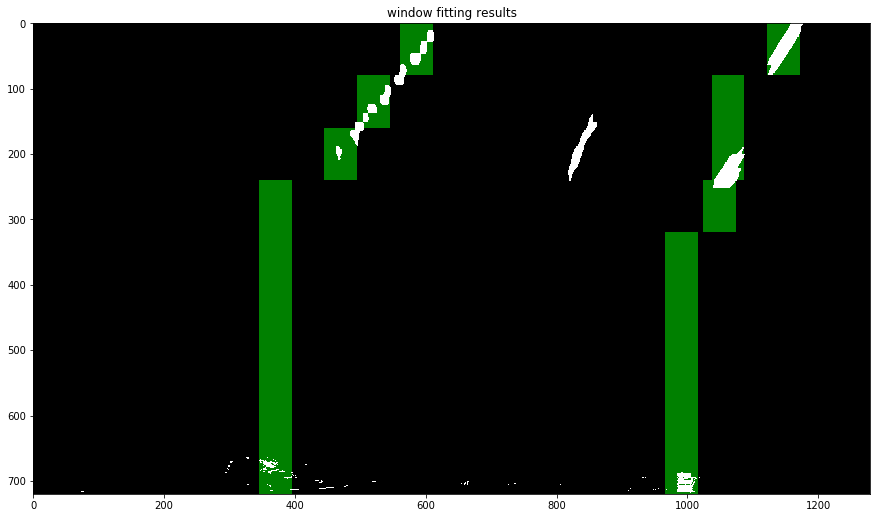